In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


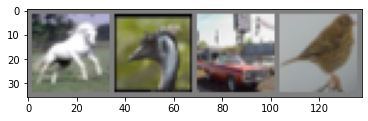

horse  bird   car  bird


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.bn = nn.BatchNorm1d(10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x_ = self.bn(x)
        batch_mean = torch.mean(x)
        batch_var = torch.var(x, unbiased=False)#, dim=[0, 2, 3], unbiased=False)
        
        return x_, self.bn.running_mean, self.bn.running_var, batch_mean, batch_var


net = Net()

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [13]:
for epoch in range(2):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs, bn_mean, bn_var, torch_mean, torch_var = net(inputs)
        
        print('>', bn_mean, bn_var)
        print('---------------------------------------')
        print('>>>', torch_mean, torch_var)
        print("=====================================================================================")
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[{}, {}] loss: {}'.format(\
                  epoch + 1, i + 1, running_loss / 2000))

            running_loss = 0.0

print('Finished Training')

> tensor([ -5.8932,  -1.0453,  -9.5329, -10.0760, -11.4429,  -7.6463,  -8.2935,
         -4.8270,  -9.4886,  -2.6972]) tensor([12.8311, 12.9764, 52.2651, 41.9863, 54.9990, 40.0811, 33.4653, 27.8206,
        27.6085, 26.0892])
---------------------------------------
>>> tensor(-5.2691, grad_fn=<MeanBackward0>) tensor(24.6992, grad_fn=<VarBackward0>)
> tensor([ -5.8311,  -0.8461,  -9.7131, -10.2247, -11.5906,  -7.7949,  -8.4893,
         -4.9112,  -9.4402,  -2.4282]) tensor([12.0522, 14.4637, 55.8802, 45.0253, 60.1726, 43.9366, 37.4239, 28.0941,
        25.8924, 24.5885])
---------------------------------------
>>> tensor(-7.4207, grad_fn=<MeanBackward0>) tensor(58.6971, grad_fn=<VarBackward0>)
> tensor([ -5.7406,  -0.8490,  -9.2256,  -9.6369, -11.1046,  -7.2465,  -8.0787,
         -4.7177,  -9.3355,  -2.3275]) tensor([11.1867, 13.1334, 53.2702, 41.7759, 58.0040, 41.2050, 33.9601, 25.4843,
        23.8722, 23.5915])
---------------------------------------
>>> tensor(-4.1202, grad_fn=<Mea

> tensor([-5.7460, -1.3093, -7.4849, -6.8669, -9.0672, -4.9362, -6.2565, -3.7125,
        -9.5140, -3.6482]) tensor([11.9351, 13.5804, 21.6818, 16.5991, 26.1464, 20.8535, 10.7247, 13.1583,
        19.4216, 23.8862])
---------------------------------------
>>> tensor(-6.6009, grad_fn=<MeanBackward0>) tensor(20.9529, grad_fn=<VarBackward0>)
> tensor([-5.8083, -1.3682, -7.7577, -7.1529, -9.3303, -5.3757, -5.8054, -4.1592,
        -9.5126, -4.0324]) tensor([12.5268, 12.6590, 25.5305, 20.0082, 28.7167, 23.0291, 16.4739, 14.9084,
        25.0129, 23.0515])
---------------------------------------
>>> tensor(-7.6152, grad_fn=<MeanBackward0>) tensor(41.6350, grad_fn=<VarBackward0>)
> tensor([-5.6198, -1.3644, -7.7044, -6.9438, -9.1250, -5.3242, -5.5787, -3.9971,
        -9.0728, -3.7692]) tensor([11.5626, 12.2789, 24.5841, 19.9804, 27.2455, 22.4679, 16.2887, 14.6013,
        24.2426, 21.5539])
---------------------------------------
>>> tensor(-4.2269, grad_fn=<MeanBackward0>) tensor(13.8076, g

>>> tensor(-6.1525, grad_fn=<MeanBackward0>) tensor(42.9415, grad_fn=<VarBackward0>)
> tensor([ -4.4111,  -0.2335,  -8.5375,  -8.2884, -10.4466,  -7.2373,  -6.6473,
         -5.2552,  -6.2761,  -3.1795]) tensor([12.2996, 17.6328, 35.4126, 27.6281, 33.2459, 25.3863, 24.5186, 16.1084,
        28.7404, 22.1804])
---------------------------------------
>>> tensor(-5.8914, grad_fn=<MeanBackward0>) tensor(31.3129, grad_fn=<VarBackward0>)
> tensor([ -4.3383,  -0.1542,  -8.5157,  -8.2344, -10.5527,  -7.1504,  -6.6766,
         -5.3251,  -6.5056,  -3.1278]) tensor([13.4778, 18.1974, 35.9542, 27.3587, 32.2526, 25.4236, 22.9877, 15.5018,
        29.0001, 22.0529])
---------------------------------------
>>> tensor(-6.1198, grad_fn=<MeanBackward0>) tensor(28.1055, grad_fn=<VarBackward0>)
> tensor([ -4.2742,  -0.4049,  -8.6216,  -8.4339, -10.5958,  -7.3323,  -6.7882,
         -5.2918,  -6.8650,  -3.3924]) tensor([15.9278, 17.8637, 37.2215, 33.0086, 36.2713, 30.5077, 28.3606, 16.7979,
        28.070

         -6.4107,  -6.6758,  -3.7636]) tensor([10.5751, 17.8082, 34.7706, 32.9739, 40.7605, 29.1087, 31.3420, 20.8434,
        21.5451, 20.7819])
---------------------------------------
>>> tensor(-6.4137, grad_fn=<MeanBackward0>) tensor(33.7296, grad_fn=<VarBackward0>)
> tensor([ -3.2750,  -1.9078, -10.4708,  -9.6281, -11.6335,  -8.4785,  -7.6013,
         -6.4444,  -6.6710,  -3.8609]) tensor([11.3944, 17.4085, 31.3614, 29.8126, 37.5249, 26.3384, 33.9058, 21.7377,
        23.9979, 19.5871])
---------------------------------------
>>> tensor(-8.2743, grad_fn=<MeanBackward0>) tensor(27.8398, grad_fn=<VarBackward0>)
> tensor([ -3.1794,  -1.5597,  -9.9205,  -9.3587, -11.3453,  -8.1192,  -7.4994,
         -6.2689,  -6.8324,  -3.5519]) tensor([10.8685, 16.8674, 31.3106, 29.2511, 35.9852, 26.5054, 31.4510, 21.1870,
        22.2978, 18.5001])
---------------------------------------
>>> tensor(-4.6614, grad_fn=<MeanBackward0>) tensor(22.1809, grad_fn=<VarBackward0>)
> tensor([ -3.1019,  -1.347

> tensor([ -5.5699,  -1.8484,  -9.2925,  -8.3943, -10.3676,  -7.2850,  -5.6525,
         -4.6369,  -9.1644,  -4.2910]) tensor([17.6837, 16.2528, 24.0447, 23.6928, 20.2397, 24.0507, 34.1353, 15.6963,
        34.6147, 17.7201])
---------------------------------------
>>> tensor(-8.0753, grad_fn=<MeanBackward0>) tensor(34.1268, grad_fn=<VarBackward0>)
> tensor([ -5.8058,  -2.0552,  -9.4193,  -8.6767, -10.2281,  -7.5100,  -5.7075,
         -4.5607,  -9.4516,  -4.5879]) tensor([19.0193, 15.6604, 21.9717, 21.4284, 19.0385, 21.7755, 32.0099, 15.7043,
        36.3037, 19.7379])
---------------------------------------
>>> tensor(-8.1506, grad_fn=<MeanBackward0>) tensor(20.3743, grad_fn=<VarBackward0>)
> tensor([ -5.5242,  -2.1278,  -9.5829,  -8.9111, -10.4697,  -7.7131,  -6.0252,
         -4.7413,  -8.9055,  -4.7255]) tensor([19.7740, 14.4322, 20.5838, 19.8848, 18.2215, 20.1537, 29.9684, 17.3378,
        36.8573, 18.0654])
---------------------------------------
>>> tensor(-7.5240, grad_fn=<Mea

> tensor([ -4.2267,   0.4773,  -8.0800,  -8.4402, -10.2750,  -7.0646,  -6.0043,
         -5.5071,  -8.6038,  -2.0498]) tensor([18.1290, 18.6222, 28.5411, 25.3275, 31.7315, 24.3719, 25.1848, 22.8718,
        31.4952, 25.3052])
---------------------------------------
>>> tensor(-5.8964, grad_fn=<MeanBackward0>) tensor(20.9202, grad_fn=<VarBackward0>)
> tensor([ -4.3754,   0.5006,  -8.5684,  -9.0437, -10.8098,  -7.7170,  -6.1044,
         -6.1137,  -8.8829,  -2.4088]) tensor([18.6029, 22.5363, 31.0776, 26.1625, 38.9193, 25.3114, 32.9722, 24.2666,
        33.0152, 24.1195])
---------------------------------------
>>> tensor(-9.7267, grad_fn=<MeanBackward0>) tensor(61.7273, grad_fn=<VarBackward0>)
> tensor([ -4.4956,   0.3927,  -8.6156,  -8.9003, -10.7504,  -7.6614,  -5.8198,
         -6.1320,  -8.7759,  -2.6294]) tensor([17.6349, 20.6961, 31.1322, 27.4773, 40.2943, 27.3466, 37.6305, 23.9947,
        34.3395, 22.3987])
---------------------------------------
>>> tensor(-6.2165, grad_fn=<Mea

> tensor([-5.0159,  0.2918, -6.5502, -6.2519, -8.6477, -4.8103, -4.4126, -3.9099,
        -9.4484, -2.4686]) tensor([14.6308, 11.6994, 18.8240, 17.8593, 21.5255, 21.3998, 20.4486, 13.8494,
        31.4124, 18.1675])
---------------------------------------
>>> tensor(-3.8901, grad_fn=<MeanBackward0>) tensor(23.5307, grad_fn=<VarBackward0>)
> tensor([-5.1495,  0.7373, -6.6748, -6.2373, -8.8617, -4.8638, -4.4946, -3.8391,
        -9.5180, -1.9165]) tensor([13.4673, 12.8968, 18.8966, 18.0274, 22.6545, 21.4898, 22.8426, 13.7492,
        28.8229, 20.2964])
---------------------------------------
>>> tensor(-4.7165, grad_fn=<MeanBackward0>) tensor(40.0605, grad_fn=<VarBackward0>)
> tensor([-5.2550,  0.6277, -6.5163, -6.0582, -8.6834, -4.6172, -4.3215, -3.7400,
        -9.6726, -2.0601]) tensor([12.9444, 12.2190, 18.2848, 17.0388, 21.7108, 21.0391, 21.7148, 13.1049,
        26.7360, 19.2405])
---------------------------------------
>>> tensor(-4.5604, grad_fn=<MeanBackward0>) tensor(15.8116, g

>>> tensor(-4.8654, grad_fn=<MeanBackward0>) tensor(15.9145, grad_fn=<VarBackward0>)
> tensor([-4.5233,  0.4441, -5.6767, -5.8007, -7.8719, -4.0148, -6.1424, -3.0203,
        -7.0797, -1.5092]) tensor([10.3422, 15.1668, 13.6232, 14.0081, 14.7459, 17.5352, 12.4829,  9.8265,
        33.4498, 23.8827])
---------------------------------------
>>> tensor(-2.3053, grad_fn=<MeanBackward0>) tensor(8.5297, grad_fn=<VarBackward0>)
> tensor([-4.4241,  0.1936, -5.7647, -5.8281, -7.7182, -4.1750, -5.9242, -3.0853,
        -6.8403, -1.7840]) tensor([10.4701, 13.8971, 14.4830, 14.1462, 15.2682, 17.3611, 14.7288,  9.6988,
        35.0154, 22.1694])
---------------------------------------
>>> tensor(-4.6747, grad_fn=<MeanBackward0>) tensor(15.9092, grad_fn=<VarBackward0>)
> tensor([-4.5040,  0.1290, -6.4614, -6.2624, -8.3655, -4.6754, -6.2984, -3.4681,
        -6.2915, -1.9283]) tensor([10.9854, 14.5424, 24.3950, 22.8546, 28.0885, 23.2440, 23.9312, 13.6744,
        37.7455, 24.2849])
------------------

>>> tensor(-4.7617, grad_fn=<MeanBackward0>) tensor(24.5271, grad_fn=<VarBackward0>)
> tensor([-5.1715, -0.2914, -7.4065, -5.7917, -8.9459, -4.3934, -5.8736, -2.8068,
        -7.4014, -3.0517]) tensor([14.7291, 19.9385, 13.0781, 15.4711, 15.5917, 15.8465, 19.3199, 10.1306,
        34.5076, 20.5147])
---------------------------------------
>>> tensor(-3.7374, grad_fn=<MeanBackward0>) tensor(9.0556, grad_fn=<VarBackward0>)
> tensor([-4.8592, -0.2844, -7.2274, -5.6516, -8.5885, -4.3419, -5.7117, -2.7094,
        -7.1352, -3.0923]) tensor([14.9272, 18.7766, 13.5173, 14.0849, 15.3458, 14.5233, 18.5717,  9.1292,
        34.4258, 19.2431])
---------------------------------------
>>> tensor(-3.5811, grad_fn=<MeanBackward0>) tensor(11.1569, grad_fn=<VarBackward0>)
> tensor([-5.4459, -0.8724, -7.7550, -5.9636, -8.9554, -4.5977, -6.1134, -2.4416,
        -7.6909, -3.7723]) tensor([22.1177, 20.7445, 18.7783, 20.1143, 19.5736, 18.2301, 24.2147, 11.1777,
        40.7942, 27.1042])
------------------

> tensor([ -7.1109,  -0.5211,  -9.5955,  -7.5333, -12.3378,  -6.2243,  -7.5158,
         -3.4377,  -9.2175,  -2.0948]) tensor([20.7238, 19.9052, 26.7879, 23.1718, 31.5089, 20.7020, 26.5212, 22.9223,
        35.8504, 54.9025])
---------------------------------------
>>> tensor(-6.1694, grad_fn=<MeanBackward0>) tensor(34.9950, grad_fn=<VarBackward0>)
> tensor([ -6.9233,  -0.2390,  -9.3689,  -7.3469, -12.0661,  -6.1252,  -7.0963,
         -3.2807,  -9.2285,  -1.8009]) tensor([19.9538, 18.6156, 24.8026, 21.4924, 29.9059, 19.7822, 24.9334, 22.9495,
        35.5165, 50.6493])
---------------------------------------
>>> tensor(-4.4460, grad_fn=<MeanBackward0>) tensor(24.7350, grad_fn=<VarBackward0>)
> tensor([ -6.8056,  -0.4573,  -9.2229,  -7.2861, -12.0469,  -5.9507,  -7.3113,
         -3.2229,  -9.1620,  -1.7681]) tensor([18.4490, 17.1096, 22.9188, 20.1462, 26.9860, 19.1676, 22.4880, 22.6171,
        33.7132, 50.9853])
---------------------------------------
>>> tensor(-6.1058, grad_fn=<Mea

> tensor([ -6.0788,   0.0247,  -8.8347,  -6.2949, -11.3399,  -5.0091,  -7.7589,
         -2.3849,  -8.7909,  -0.9868]) tensor([14.6005, 13.2216, 16.2926, 17.8012, 23.1093, 17.0113, 17.4978, 13.8204,
        24.4737, 38.0002])
---------------------------------------
>>> tensor(-5.6558, grad_fn=<MeanBackward0>) tensor(18.6975, grad_fn=<VarBackward0>)
> tensor([ -6.2631,  -0.1554,  -8.7183,  -5.9977, -11.1368,  -4.7299,  -7.5403,
         -2.3310,  -9.2844,  -1.5286]) tensor([16.0941, 13.0827, 17.4455, 16.3537, 24.8675, 15.4432, 22.3469, 13.4162,
        27.9517, 39.9857])
---------------------------------------
>>> tensor(-5.9768, grad_fn=<MeanBackward0>) tensor(36.4599, grad_fn=<VarBackward0>)
> tensor([ -6.4531,  -0.3505,  -8.9005,  -5.7553, -11.4219,  -4.3691,  -7.8907,
         -2.5449,  -9.6972,  -2.0512]) tensor([17.3099, 12.4816, 17.4666, 15.5514, 27.7815, 15.7099, 21.2441, 17.9393,
        28.4205, 40.6616])
---------------------------------------
>>> tensor(-7.5175, grad_fn=<Mea

KeyboardInterrupt: 

In [7]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()
print(len(images), len(labels))

4 4


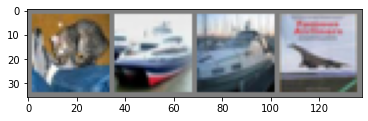

GroundTruth:    cat  ship  ship plane


In [9]:
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [14]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [16]:
outputs = net(images)
print(outputs)

tensor([[-1.6367, -1.9621,  0.9884,  2.7267, -0.0979,  1.8934,  2.2154, -0.6151,
         -2.1048, -0.5249],
        [ 3.2831,  4.2747, -1.6208, -2.1070, -2.0058, -3.4003, -3.1891, -1.2473,
          3.9636,  3.8717],
        [ 1.8277,  1.2513, -0.3616, -0.9519,  0.1978, -1.8151, -2.0616,  0.0177,
          0.8379,  1.7618],
        [ 3.7110,  0.4996,  0.5006, -1.4650,  0.4490, -2.3945, -2.6184, -1.1689,
          2.8897,  0.5425]], grad_fn=<AddmmBackward>)


In [18]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car plane plane


In [ ]:
sudo mount -t nfs 192.168.1.74:/volume1/Datasets /mnt/datasets

In [19]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


In [20]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 72 %
Accuracy of   car : 49 %
Accuracy of  bird : 40 %
Accuracy of   cat : 32 %
Accuracy of  deer : 45 %
Accuracy of   dog : 44 %
Accuracy of  frog : 72 %
Accuracy of horse : 66 %
Accuracy of  ship : 52 %
Accuracy of truck : 75 %
